# Introduction: Cardiovascular disease prediction
To predict positive or negative cases of cardiovascular disease a dataset from Kaggle.com was used. The dataset consisted of 12 biometric features plus a label. Three classification modells where trained on the dataset and the one with best performance in terms of accuracy and recall score was selected as production model.
  
The selection of the model as achieved through training on each model on two version of the dataset, one with and one without feature engineering, for a total on 6 trained models. 50% of data was subset as training data. The best performing model in line with appropriate evaluation strategy for project purpose was selected as production model.

To scale the data Scitkit-learns "standardscaler" was used for the KNN & logistic regression modell.  
  
$X' = \frac{X-\mu}{\sigma}$  


## 1.1 EDA
The dataset came in a csv file but was separated by semi-colons. 
  
No missing values where found but values where predominantly string numerals ("object" datatype), that were reformated for effective memory usage. 
 
Age features was reformated from days to represent approximate years in days. Lifestyle features (smoking, drinking & physical activity) where inversed from 0 = yes & 1 = no to 0 = no & 1 = yes.
Outliers where filtered, first in blood pressure features (systolic_bp & diastolic_bp) to include only highest/lowest recorded values. Later in the engineered feature BMI to exclude under weight & class 4 obesity.  
  
Dataset was not found to be imbalanced.  
  
- - -
  
As displayed in the heatmap majority of features had weak correlation to label, gender displaying weakests correlation(0.0072). Moderate correlation was found in blood pressure features systolic_bp (0.43) & diastolic_bp (0.33). When merged into "bp_category" through feature engineering the correlation remained moderate (0.34).  
  
- - -  
    
### Model selection:  
The dataset was split into two sets. One with feature engineering and one without, train|test split of was 50% for both. All three models were tested on both sets of data.
  
The models trained where K-nearest neighbor, logistic regression & random forest. GridsearchCV was applied to select optimal hyperparameters such as nearest neighbors, regularization technique, iterations and amount of decision trees to build. Number of cross-validations chosen was 5 and evaluation strategy chosen for every model was "recall".
  
The KNN model was tested on up to 49 neighbors but found to perform optimally with 5 neighbors, without feature engineering. Overall performance was better on dataset without feature engineering.  
Training time was 14 minutes + 6.0 seconds on dataset with 33,948 samples with 11 parameters (df_2) and 6 minutes + 10.6 seconds on dataset with 17 parameters (dummy encoded).
  

### Result  

|Model|Precision|Recall|Accuracy|F1-score|
|---|---|---|---|---|
|Positive cases, with feat. eng.|
|KNN|0.68|0.66|0.68|0.67|
|Log. Reg.|0.73|0.63|0.70|0.68|
|Rand. For.|0.70|0.64|0.68|0.66|
|Averages|0.70|0.64|0.66||
|Positive cases, w/o feat. eng.|
|KNN|0.72|**0.69**|0.71|0.70|
|Log. Reg.|**0.75**|0.67|**0.73**|0.71|
|Rand. For.|0.68|0.68|0.69|0.68|
|Averages|0.717|0.68|0.71||
|Negative cases, with feat. eng.|
|KNN|0.67|0.69|0.68|0.68|
|Log. Reg.|0.68|0.77|0.70|0.72|
|Rand. For.|0.67|0.73|0.68|0.70|
|Negative cases, w/o feat. eng.|
|KNN|0.70|0.74|0.71|0.72|
|Log. Reg.|0.70|0.78|0.73|0.74|
|Rand. For.|0.69|0.69|0.69|0.69|


Out of the three models tested it was the K-nearest neighbors (KNN) model that performed most desirable, scoring highest in terms of recall both with feature engineering (0.66) and without (0.69). It also scored second highest in terms of precision (0.72) and accuracy (0.71) on the dataset without feature engineering.  
  
Ultimately KNN was chosen as production model for performing most desirable in terms of recall score for positive cases. The reason being that the higher percentage of positive cases are detected the more human lives can be saved, a 1-2% unit increase can translate to millions of people getting diagnosed in time.  

      

### Discussion  
   
The models scored decently on positive cases. Recall score averaged at 0.66 between all 6. Precision score could be better, averaging at 0.71. Interestingly enough the modell without feature engineering performed better, indicating either poorly chosen features to engineer or the need for additional models to be trained and tested on the data.  
  
Dataset contained samples unusual but not necessarily attributed to human error.  
Humans on ends of the spectrum, perhaps diagnosed with dwarfism or gigantism, where filtered away in favor of better performance on general population. An additional feature containing other conditions might improve results for samples in the filtered datasets on ends on the spectrum.  
A majority of positive cases where females prompting the question whether cardiovascular disease is a predominantly female condition, needing a separates models due to biological & therefore lifestyle differences.  






In [1]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

csv = 'cardio_data.csv'
df = pd.read_csv(csv)

df.head()

,id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0,0;18393;2;168;62.0;110;80;1;1;0;0;1;0
1,1;20228;1;156;85.0;140;90;3;1;0;0;1;1
2,2;18857;1;165;64.0;130;70;3;1;0;0;0;1
3,3;17623;2;169;82.0;150;100;1;1;0;0;1;1
4,4;17474;1;156;56.0;100;60;1;1;0;0;0;0


In [2]:

new_columns = df['id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio'].str.split(';', expand=True) #Chat GPT
df[new_columns.columns] = new_columns 
df.drop('id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio', axis=1, inplace=True)

df.columns = [ 'id', 'age', 'gender', 'height_cm', 
              'weight_kg', 'systolic_bp', 'diastolic_bp', 'cholesterol_lvl', 
              'glucose_lvl', 'smokes', 'drinks', 'trains', 'cardio_diseas']

df.head()

,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               70000 non-null  object
 1   age              70000 non-null  object
 2   gender           70000 non-null  object
 3   height_cm        70000 non-null  object
 4   weight_kg        70000 non-null  object
 5   systolic_bp      70000 non-null  object
 6   diastolic_bp     70000 non-null  object
 7   cholesterol_lvl  70000 non-null  object
 8   glucose_lvl      70000 non-null  object
 9   smokes           70000 non-null  object
 10  drinks           70000 non-null  object
 11  trains           70000 non-null  object
 12  cardio_diseas    70000 non-null  object
dtypes: object(13)
memory usage: 6.9+ MB


In [4]:
df.describe()

,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas
count,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000,70000
unique,70000,8076,2,109,287,153,157,3,3,2,2,2,2
top,0,19741,1,165,65.0,120,80,1,1,0,0,1,0
freq,1,32,45530,5853,3850,27699,34847,52385,59479,63831,66236,56261,35021


In [5]:
df.max()

id                 99999
age                23713
gender                 2
height_cm             99
weight_kg           99.9
systolic_bp           99
diastolic_bp          99
cholesterol_lvl        3
glucose_lvl            3
smokes                 1
drinks                 1
trains                 1
cardio_diseas          1
dtype: object

In [6]:
df.min()

id                     0
age                10798
gender                 1
height_cm            100
weight_kg           10.0
systolic_bp         -100
diastolic_bp         -70
cholesterol_lvl        1
glucose_lvl            1
smokes                 0
drinks                 0
trains                 0
cardio_diseas          0
dtype: object

In [7]:
def days_to_years(age_days):
    from math import ceil as rnd

    age_days = int(age_days)

    cycles = age_days // (365*3+366)*4 # x 4 years
    left_years = age_days % (365*3+366)
    extra_years = left_years // 365

    year_age = cycles + extra_years

    days_left = left_years % 365
    pct_of_year = days_left / 365

    # # # 
    total_age = year_age + pct_of_year
    difference = total_age - int(total_age)
    age_in_years = int(total_age) if difference < 0.5 else rnd(total_age)

    return age_in_years


df['age'] = df['age'].map(days_to_years)

df.head()



,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
dtypes = [np.int32, np.int8, np.int8, np.int16, np.float32, np.int16, np.int16, np.int8, np.int8, np.int8, np.int8, np.int8, np.int8, np.int8]

for dtype, col in enumerate(df):
    df[col] = df[col].apply(dtypes[dtype])


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               70000 non-null  int32  
 1   age              70000 non-null  int8   
 2   gender           70000 non-null  int8   
 3   height_cm        70000 non-null  int16  
 4   weight_kg        70000 non-null  float32
 5   systolic_bp      70000 non-null  int16  
 6   diastolic_bp     70000 non-null  int16  
 7   cholesterol_lvl  70000 non-null  int8   
 8   glucose_lvl      70000 non-null  int8   
 9   smokes           70000 non-null  int8   
 10  drinks           70000 non-null  int8   
 11  trains           70000 non-null  int8   
 12  cardio_diseas    70000 non-null  int8   
dtypes: float32(1), int16(3), int32(1), int8(8)
memory usage: 1.5 MB


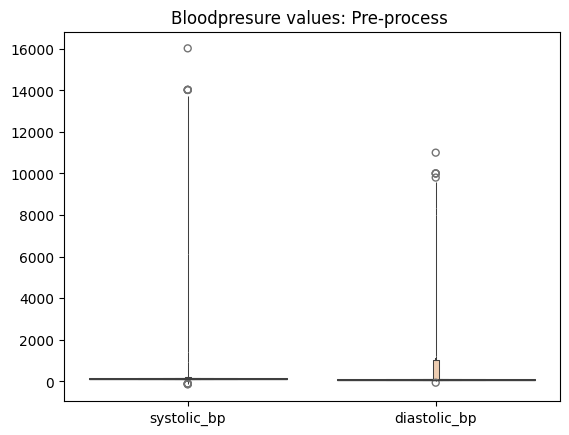

In [9]:
sns.boxenplot(data=df[['systolic_bp', 'diastolic_bp']]).set(title='Bloodpresure values: Pre-process ');

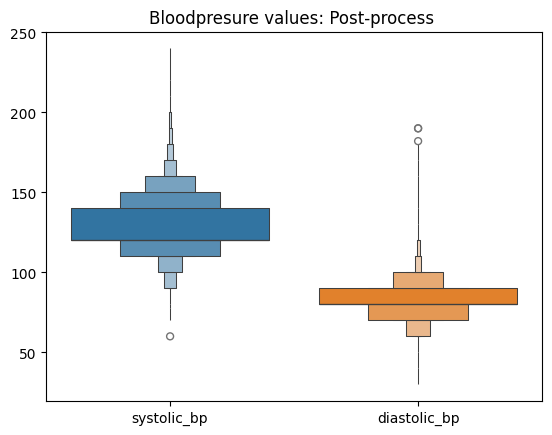

In [10]:
df = df[(50 < df['systolic_bp']) & (df['systolic_bp'] < 370) & (20 < df['diastolic_bp']) & (df['diastolic_bp'] < 360)]

sns.boxenplot(data=df[['systolic_bp', 'diastolic_bp']]).set(title='Bloodpresure values: Post-process ');

In [11]:
value_inverser = lambda x: 1 if x == 0 else 0

for col in ['smokes', 'trains', 'drinks']:
    df.loc[:, col] = df[col].map(value_inverser)

df

,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas
0,0,50,2,168,62.0,110,80,1,1,1,1,0,0
1,1,55,1,156,85.0,140,90,3,1,1,1,0,1
2,2,52,1,165,64.0,130,70,3,1,1,1,1,1
3,3,48,2,169,82.0,150,100,1,1,1,1,0,1
4,4,48,1,156,56.0,100,60,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,0,1,0,0
69996,99995,62,1,158,126.0,140,90,2,2,1,1,0,1
69997,99996,52,2,183,105.0,180,90,3,1,1,0,1,1
69998,99998,61,1,163,72.0,135,80,1,2,1,1,1,1


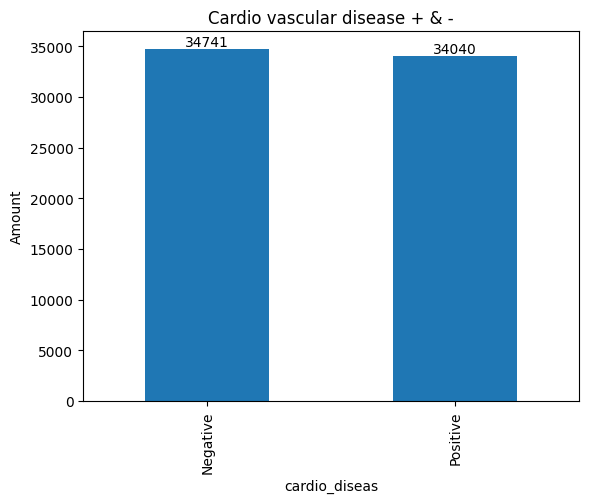

In [12]:
cardio_plot = df['cardio_diseas'].value_counts().plot(kind='bar') 
cardio_plot.set_xticklabels(['Negative', 'Positive'])
cardio_plot.set_ylabel('Amount')
cardio_plot.set_title('Cardio vascular disease + & -');

for container in cardio_plot.containers: # geeks for geeks
    cardio_plot.bar_label(container)


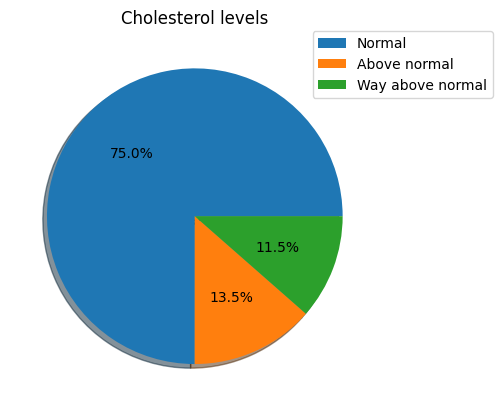

In [13]:
choles_plot = df['cholesterol_lvl'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, legend=True, ylabel='', labeldistance=None) #stackoverflow

choles_plot.set_title('Cholesterol levels');

choles_plot.legend(['Normal','Above normal','Way above normal'],bbox_to_anchor=(.8, 1.02), loc='upper left')
plt.show()


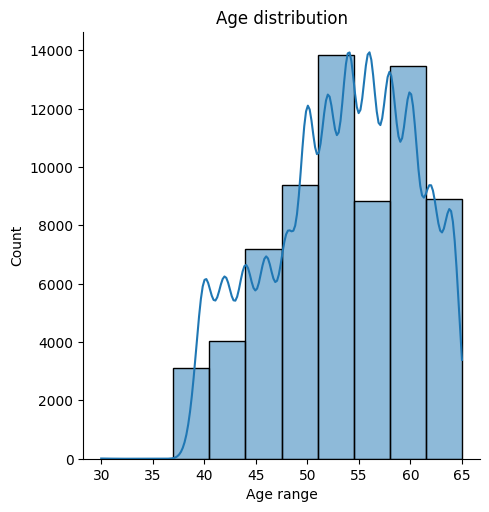

In [14]:
sns.displot(df['age'],kde=True,bins=10)
plt.xlabel("Age range")
plt.title("Age distribution");



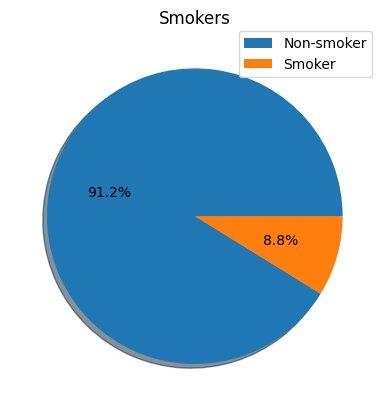

In [15]:
smoke_plot = df['smokes'].value_counts().plot(kind='pie', autopct='%1.1f%%', shadow=True, legend=True, ylabel='', labeldistance=None) #stackoverflow

smoke_plot.set_title('Smokers');

smoke_plot.legend(['Non-smoker','Smoker'],bbox_to_anchor=(.6, 1.02), loc='upper left')
plt.show()


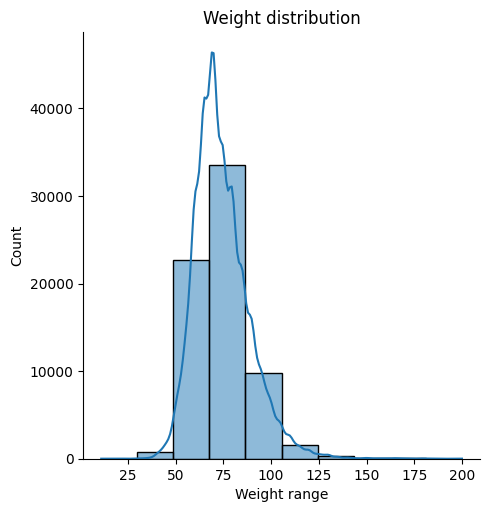

In [16]:
sns.displot(df['weight_kg'],kde=True,bins=10)
plt.xlabel("Weight range")
plt.title("Weight distribution");



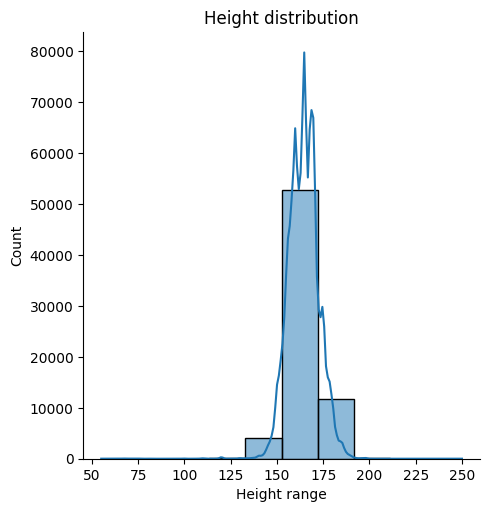

In [17]:
sns.displot(df['height_cm'],kde=True,bins=10)
plt.xlabel("Height range")
plt.title("Height distribution");



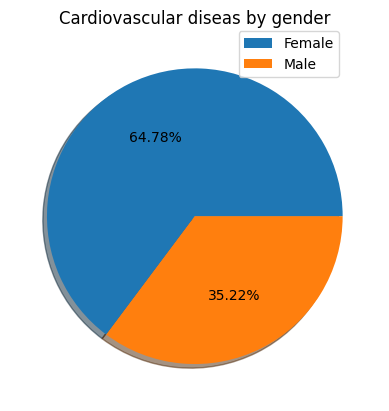

In [18]:
positive_df = df[df['cardio_diseas'] == 1]

cardio_by_gender = positive_df[['gender', 'cardio_diseas']].groupby('gender').value_counts()

cardio_gender_plot = cardio_by_gender.plot(kind='pie', autopct='%1.2f%%', shadow=True, legend=True, ylabel='', labeldistance=None) #stackoverflow
cardio_gender_plot.set_title('Cardiovascular diseas by gender');
cardio_gender_plot.legend(['Female','Male'],bbox_to_anchor=(.6, 1.02), loc='upper left')
plt.show()


## 1.2 Model design

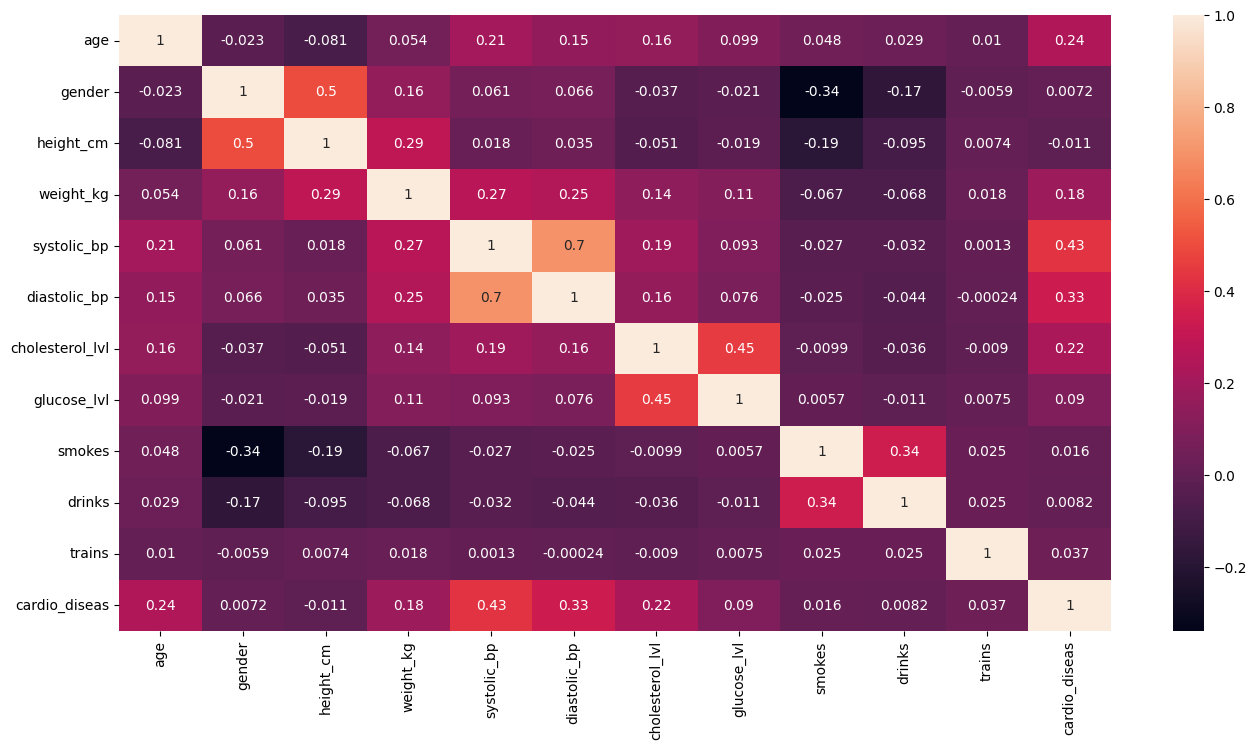

In [19]:
f, ax = plt.subplots(figsize=(16,8))

heatmap_df = df.drop('id', axis=1)

sns.heatmap(heatmap_df.corr(), annot=True, ax=ax);


## 1.2.1 Feature Engineering  


In [20]:
def bmi_encoding(bmi_value):

    if bmi_value < 18.5: # underweight
        bmi_code = -1

    if 18.5 <= bmi_value <= 24.9: # normal weight
        bmi_code = 0

    elif 24.9 < bmi_value <= 29.9: # over weight
        bmi_code = 1

    elif 29.9 < bmi_value <= 34.9: # obese class 1
        bmi_code = 2

    elif 34.9 < bmi_value <= 39.9: # class 2
        bmi_code = 3

    elif 39.9 < bmi_value <= 49.9: # class 3 
        bmi_code = 4

    elif bmi_value > 49.9: # class 4
        bmi_code = 5


    return bmi_code

df.loc[:, 'bmi'] = df['weight_kg'] / np.square((df['height_cm']*.01)) # x 0.01 convert cm to m

df['bmi_cat'] = df['bmi'].map(bmi_encoding)

df.head()

,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas,bmi,bmi_cat
0,0,50,2,168,62.0,110,80,1,1,1,1,0,0,21.967120,0
1,1,55,1,156,85.0,140,90,3,1,1,1,0,1,34.927679,3
2,2,52,1,165,64.0,130,70,3,1,1,1,1,1,23.507805,0
3,3,48,2,169,82.0,150,100,1,1,1,1,0,1,28.710479,1
4,4,48,1,156,56.0,100,60,1,1,1,1,1,0,23.011177,0


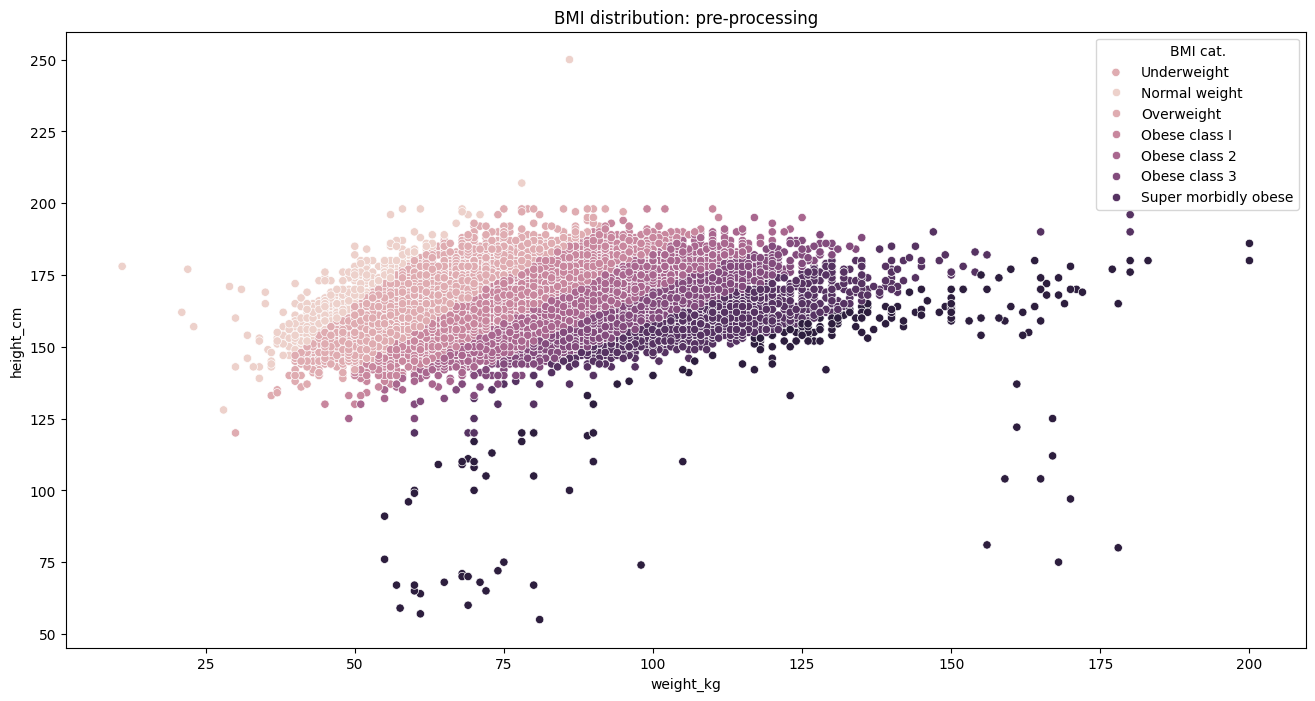

In [21]:
f, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(x='weight_kg', y='height_cm', data=df, hue='bmi_cat', ax=ax)
plt.legend(title='BMI cat.', labels=['Underweight', 'Normal weight', 'Overweight', 'Obese class I', 'Obese class 2', 'Obese class 3', 'Super morbidly obese'])
plt.title("BMI distribution: pre-processing");


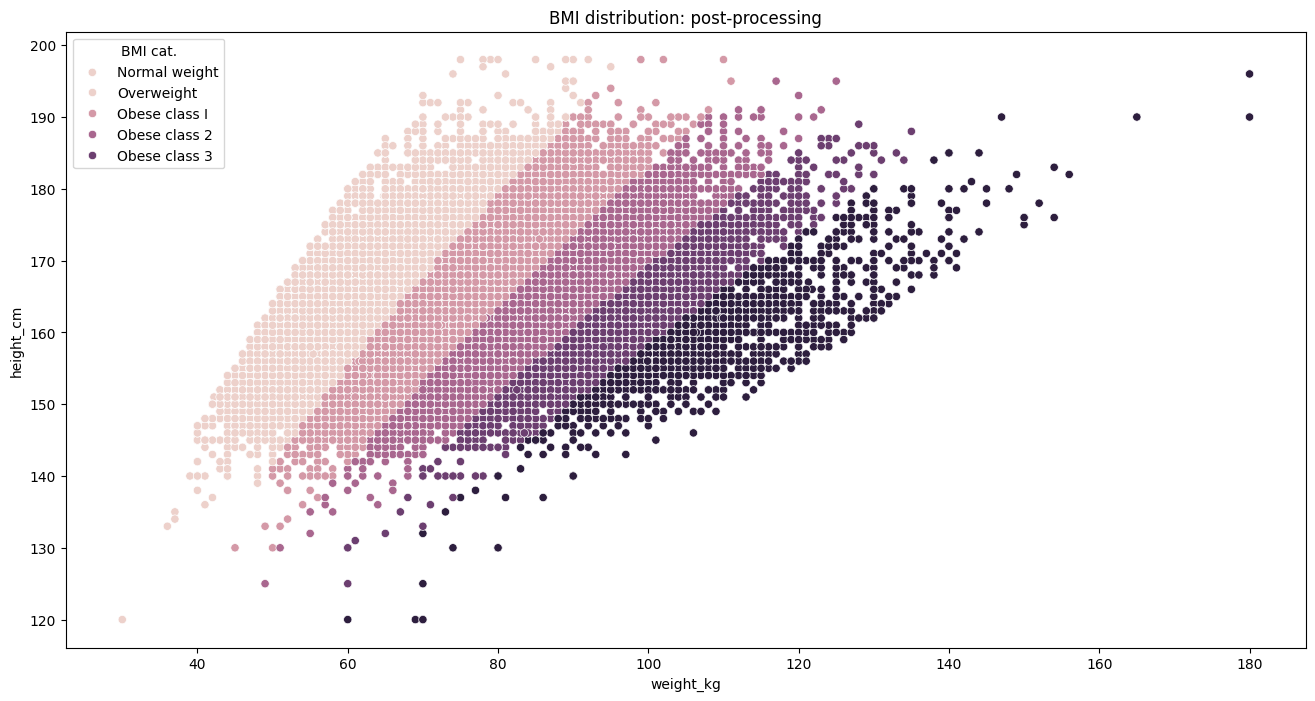

In [22]:
df = df[(df['bmi_cat'].isin([0,1,2,3,4]))]

f, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(x='weight_kg', y='height_cm', data=df, hue='bmi_cat', ax=ax)
plt.legend(title='BMI cat.', labels=['Normal weight', 'Overweight', 'Obese class I', 'Obese class 2', 'Obese class 3'])
plt.title("BMI distribution: post-processing");


In [23]:
def bp_encoding(sys, dias):

    if (sys < 120) & (dias < 80): # healthy
        code = 0

    elif (120 <= sys <= 129) & (dias < 80): # elevated
        code = 1

    elif (129 < sys <= 139) | (80 <= dias <= 89): # stage 1 hypertension
        code = 2

    elif (139 < sys) | (dias > 89): # stage 2 hypertension
        code = 3

    elif (sys > 180) | (dias > 120): # stage 3 hypertension
        code = 4
    
    return code

df.loc[:,'bp_category'] = df.apply(lambda x: bp_encoding(x['systolic_bp'], x['diastolic_bp']), axis=1) #stackoverflow


df = df[['id', 'age', 'gender', 'height_cm', 'weight_kg', 'systolic_bp', 'diastolic_bp', 'cholesterol_lvl', 'glucose_lvl', 'smokes', 'drinks', 'trains', 'bmi', 'bmi_cat', 'bp_category', 'cardio_diseas']]

df.head()


C:\Users\Alejandro Martinez\AppData\Local\Temp\ipykernel_15344\1813524510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'bp_category'] = df.apply(lambda x: bp_encoding(x['systolic_bp'], x['diastolic_bp']), axis=1) #stackoverflow


,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,bmi,bmi_cat,bp_category,cardio_diseas
0,0,50,2,168,62.0,110,80,1,1,1,1,0,21.967120,0,2,0
1,1,55,1,156,85.0,140,90,3,1,1,1,0,34.927679,3,3,1
2,2,52,1,165,64.0,130,70,3,1,1,1,1,23.507805,0,2,1
3,3,48,2,169,82.0,150,100,1,1,1,1,0,28.710479,1,3,1
4,4,48,1,156,56.0,100,60,1,1,1,1,1,23.011177,0,0,0


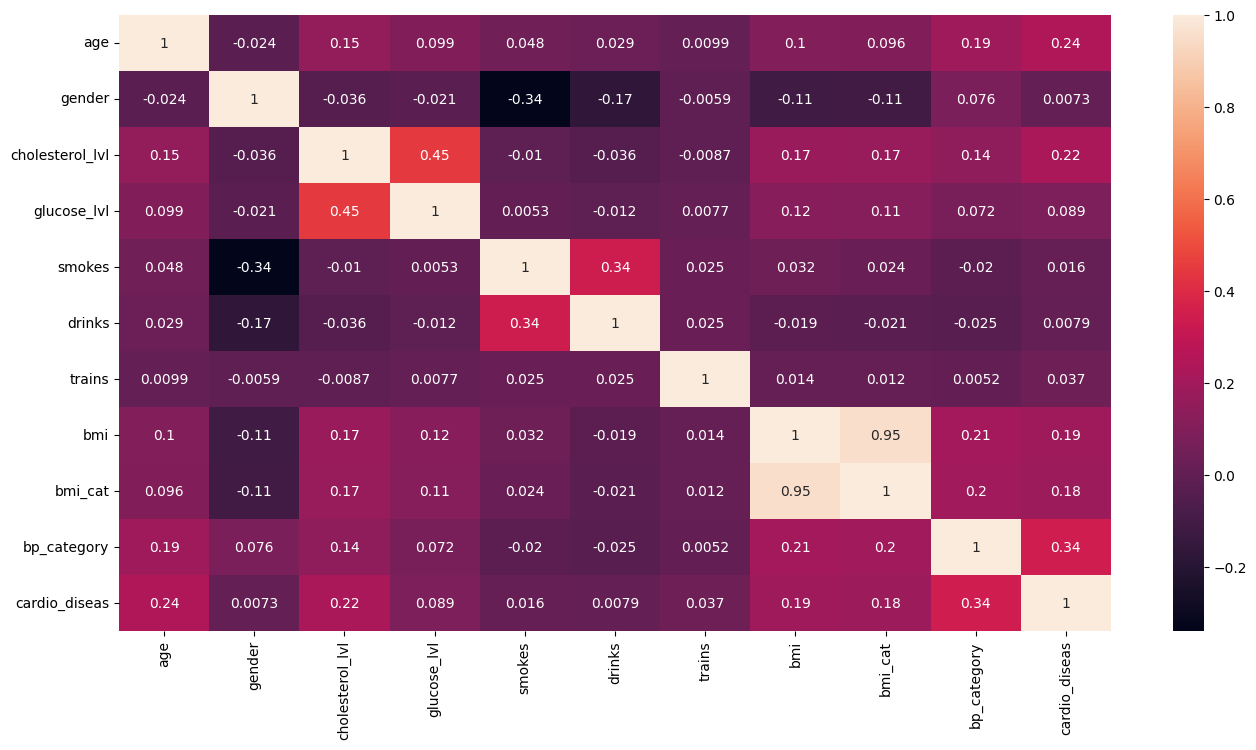

In [24]:
f, ax = plt.subplots(figsize=(16,8))

heatmap_df = df.drop(['id', 'systolic_bp', 'diastolic_bp', 'height_cm', 'weight_kg'], axis=1)

sns.heatmap(heatmap_df.corr(), annot=True, ax=ax);


## 1.2.2 Two datasets

In [25]:
df_1 = df.copy()
df_2 = df.copy()

df_1 = df_1.drop(['id', 'systolic_bp', 'bmi', 'diastolic_bp', 'height_cm', 'weight_kg'], axis=1) #ta bort följande features: ap_hi, ap_lo, height, weight, BMI
df_1 = pd.get_dummies(df_1, columns = ['bmi_cat', 'bp_category','gender'], dtype=int) # gör one-hot encoding på BMI-kategori, blodtryckskategori och kön

df_2 = df_2.drop(['id', 'bmi_cat', 'bp_category', 'height_cm', 'weight_kg'], axis=1) # ta bort följande features: BMI-kategori, blodtryckskategori, height, weight
df_2 = pd.get_dummies(df_2, columns = ['gender'], dtype=int) # gör one-hot encoding på kön

df_1

,age,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,cardio_diseas,bmi_cat_0,bmi_cat_1,bmi_cat_2,bmi_cat_3,bmi_cat_4,bp_category_0,bp_category_1,bp_category_2,bp_category_3,gender_1,gender_2
0,50,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1
1,55,3,1,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0
2,52,3,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0
3,48,1,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1
4,48,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,58,1,1,1,1,0,1,0,1,0,0,0,0,0,1,0,1,0
69995,53,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
69997,52,3,1,1,0,1,1,0,0,1,0,0,0,0,0,1,0,1
69998,61,1,2,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0


## 1.2.3 Execution
   


In [26]:
X, y = df_1.drop('cardio_diseas', axis=1), df_1['cardio_diseas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((33948, 17), (33949, 17), (33948,), (33949,))

In [27]:
scaler = StandardScaler()

pipe_knn = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])

param_grid_knn = {"knn__n_neighbors":list(range(1,50))}

classifier_knn = GridSearchCV(
    estimator=pipe_knn, param_grid=param_grid_knn, cv=5, scoring='recall'
)


In [28]:
classifier_knn.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='recall')

In [29]:
pipe_log = make_pipeline(scaler, LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100_000))

param_grid_logistic = {"logisticregression__l1_ratio": np.linspace(0, 1, 20)}

classifier_log = GridSearchCV(
    estimator=pipe_log, param_grid=param_grid_logistic, cv=5, scoring='recall'
)


In [30]:
classifier_log.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=100000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'logisticregression__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='recall')

In [31]:
pipe_forest = Pipeline([('forest', RandomForestClassifier())])

params_forest = {'forest__n_estimators': list(range(50, 200, 10))}

classifier_forest = GridSearchCV(estimator=pipe_forest, param_grid=params_forest, cv=5, scoring='recall')


In [32]:
classifier_forest.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest', RandomForestClassifier())]),
             param_grid={'forest__n_estimators': [50, 60, 70, 80, 90, 100, 110,
                                                  120, 130, 140, 150, 160, 170,
                                                  180, 190]},
             scoring='recall')

In [33]:

classifier_knn.best_estimator_.get_params()


{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=11))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=11),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 11,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [34]:

classifier_log.best_estimator_.get_params()


{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(l1_ratio=0.0, max_iter=100000, penalty='elasticnet',
                      solver='saga'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(l1_ratio=0.0, max_iter=100000, penalty='elasticnet',
                    solver='saga'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': 0.0,
 'logisticregression__max_iter': 100000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'saga',
 'logisticregressi

In [35]:

classifier_forest.best_estimator_.get_params()


{'memory': None,
 'steps': [('forest', RandomForestClassifier(n_estimators=130))],
 'verbose': False,
 'forest': RandomForestClassifier(n_estimators=130),
 'forest__bootstrap': True,
 'forest__ccp_alpha': 0.0,
 'forest__class_weight': None,
 'forest__criterion': 'gini',
 'forest__max_depth': None,
 'forest__max_features': 'sqrt',
 'forest__max_leaf_nodes': None,
 'forest__max_samples': None,
 'forest__min_impurity_decrease': 0.0,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 2,
 'forest__min_weight_fraction_leaf': 0.0,
 'forest__n_estimators': 130,
 'forest__n_jobs': None,
 'forest__oob_score': False,
 'forest__random_state': None,
 'forest__verbose': 0,
 'forest__warm_start': False}

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     17076
           1       0.68      0.66      0.67     16873

    accuracy                           0.68     33949
   macro avg       0.68      0.68      0.68     33949
weighted avg       0.68      0.68      0.68     33949



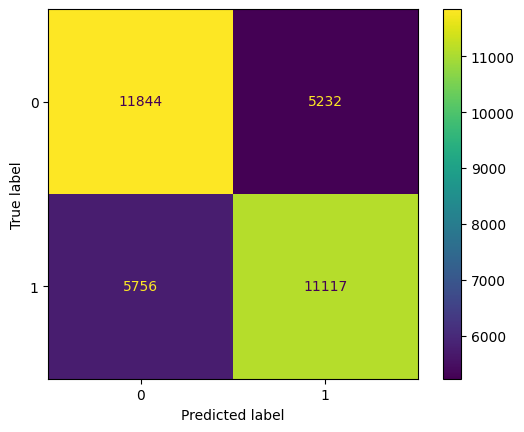

In [36]:
y_pred_knn = classifier_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm).plot()

# 66

              precision    recall  f1-score   support

           0       0.68      0.77      0.72     17076
           1       0.73      0.63      0.68     16873

    accuracy                           0.70     33949
   macro avg       0.70      0.70      0.70     33949
weighted avg       0.70      0.70      0.70     33949



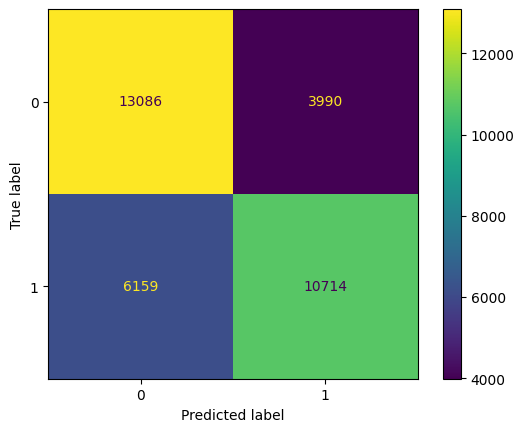

In [37]:
y_pred_log = classifier_log.predict(X_test)

print(classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm).plot()

# 63

              precision    recall  f1-score   support

           0       0.67      0.73      0.70     17076
           1       0.70      0.63      0.66     16873

    accuracy                           0.68     33949
   macro avg       0.68      0.68      0.68     33949
weighted avg       0.68      0.68      0.68     33949



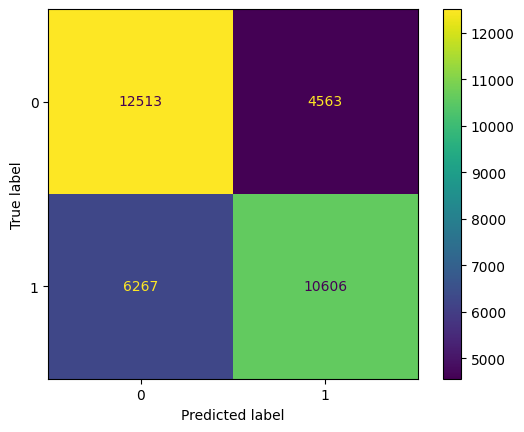

In [38]:
y_pred_forest = classifier_forest.predict(X_test)

print(classification_report(y_test, y_pred_forest))
cm = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cm).plot()

# 64

In [39]:
X, y = df_2.drop('cardio_diseas', axis=1), df_2['cardio_diseas']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((33948, 11), (33949, 11), (33948,), (33949,))

In [40]:
scaler = StandardScaler()

pipe_knn = Pipeline([('scaler', scaler), ('knn', KNeighborsClassifier())])

param_grid_knn = {"knn__n_neighbors":list(range(1,50))}

classifier_knn = GridSearchCV(
    estimator=pipe_knn, param_grid=param_grid_knn, cv=5, scoring='recall'
)


In [41]:
classifier_knn.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='recall')

In [42]:
pipe_log = make_pipeline(scaler, LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100_000))

param_grid_logistic = {"logisticregression__l1_ratio": np.linspace(0, 1, 20)}

classifier_log = GridSearchCV(
    estimator=pipe_log, param_grid=param_grid_logistic, cv=5, scoring='recall'
)


In [43]:
classifier_log.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=100000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'logisticregression__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
             scoring='recall')

In [44]:
pipe_forest = Pipeline([('forest', RandomForestClassifier())])

params_forest = {'forest__n_estimators': list(range(50, 200, 10))}

classifier_forest = GridSearchCV(estimator=pipe_forest, param_grid=params_forest, cv=5, scoring='recall')


In [45]:
classifier_forest.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest', RandomForestClassifier())]),
             param_grid={'forest__n_estimators': [50, 60, 70, 80, 90, 100, 110,
                                                  120, 130, 140, 150, 160, 170,
                                                  180, 190]},
             scoring='recall')

In [46]:
classifier_knn.get_params()

# 5

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier())],
 'estimator__verbose': False,
 'estimator__scaler': StandardScaler(),
 'estimator__knn': KNeighborsClassifier(),
 'estimator__scaler__copy': True,
 'estimator__scaler__with_mean': True,
 'estimator__scaler__with_std': True,
 'estimator__knn__algorithm': 'auto',
 'estimator__knn__leaf_size': 30,
 'estimator__knn__metric': 'minkowski',
 'estimator__knn__metric_params': None,
 'estimator__knn__n_jobs': None,
 'estimator__knn__n_neighbors': 5,
 'estimator__knn__p': 2,
 'estimator__knn__weights': 'uniform',
 'estimator': Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
 'n_jobs': None,
 'param_grid': {'knn__n_neighbors': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30

In [47]:
classifier_log.best_estimator_.get_params()

# 0.21052631578947367

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(l1_ratio=0.3157894736842105, max_iter=100000,
                      penalty='elasticnet', solver='saga'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(l1_ratio=0.3157894736842105, max_iter=100000,
                    penalty='elasticnet', solver='saga'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': 0.3157894736842105,
 'logisticregression__max_iter': 100000,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'elasticnet',
 'logisticregression__random_state': None,
 'logisticre

In [48]:

classifier_forest.get_params()


{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('forest', RandomForestClassifier())],
 'estimator__verbose': False,
 'estimator__forest': RandomForestClassifier(),
 'estimator__forest__bootstrap': True,
 'estimator__forest__ccp_alpha': 0.0,
 'estimator__forest__class_weight': None,
 'estimator__forest__criterion': 'gini',
 'estimator__forest__max_depth': None,
 'estimator__forest__max_features': 'sqrt',
 'estimator__forest__max_leaf_nodes': None,
 'estimator__forest__max_samples': None,
 'estimator__forest__min_impurity_decrease': 0.0,
 'estimator__forest__min_samples_leaf': 1,
 'estimator__forest__min_samples_split': 2,
 'estimator__forest__min_weight_fraction_leaf': 0.0,
 'estimator__forest__n_estimators': 100,
 'estimator__forest__n_jobs': None,
 'estimator__forest__oob_score': False,
 'estimator__forest__random_state': None,
 'estimator__forest__verbose': 0,
 'estimator__forest__warm_start': False,
 'estimator': Pipeline(steps=[('forest', RandomFor

              precision    recall  f1-score   support

           0       0.70      0.74      0.72     17076
           1       0.72      0.69      0.70     16873

    accuracy                           0.71     33949
   macro avg       0.71      0.71      0.71     33949
weighted avg       0.71      0.71      0.71     33949



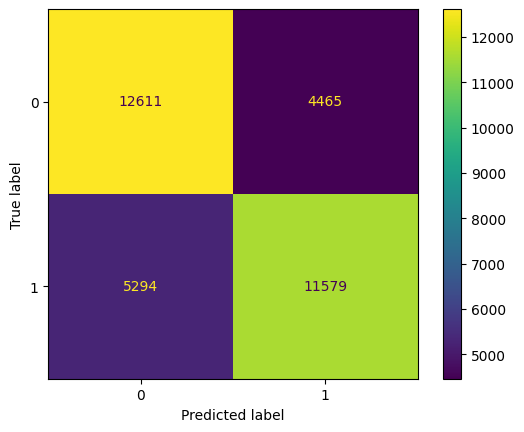

In [49]:
y_pred_knn = classifier_knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
ConfusionMatrixDisplay(cm).plot()

# 69

              precision    recall  f1-score   support

           0       0.70      0.78      0.74     17076
           1       0.75      0.67      0.71     16873

    accuracy                           0.73     33949
   macro avg       0.73      0.73      0.73     33949
weighted avg       0.73      0.73      0.73     33949



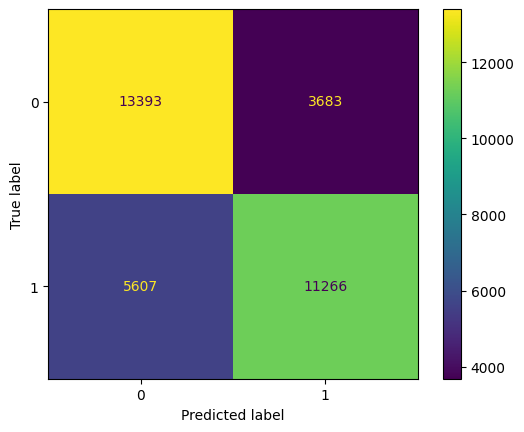

In [50]:
y_pred_log = classifier_log.predict(X_test)

print(classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm).plot()

#66

              precision    recall  f1-score   support

           0       0.69      0.69      0.69     17076
           1       0.68      0.69      0.69     16873

    accuracy                           0.69     33949
   macro avg       0.69      0.69      0.69     33949
weighted avg       0.69      0.69      0.69     33949



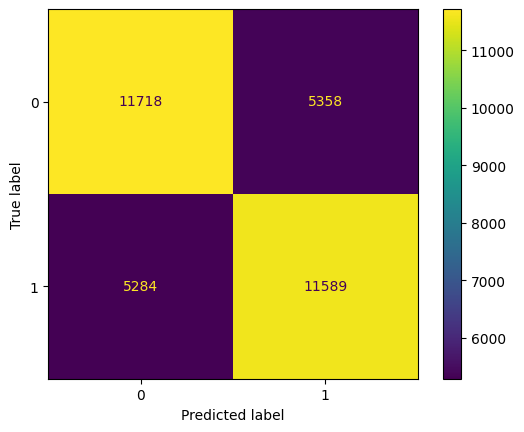

In [51]:
y_pred_forest = classifier_forest.predict(X_test)

print(classification_report(y_test, y_pred_forest))
cm = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cm).plot()

#66

In [52]:
import random

random_rows = list()


while True:
    row = random.randint(0, len(df_1))
    random_rows.append(row)

    test_samples = df[df['id'].isin(random_rows)]   

    if len(test_samples) == 100:
        test_samples.to_csv('test_sample.csv', index=False)  
        break


In [53]:
df_samples = pd.read_csv('test_sample.csv')

ids = list(df_samples['id'])

train_df = df[~df['id'].isin(ids)]

train_df

,id,age,gender,height_cm,weight_kg,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,bmi,bmi_cat,bp_category,cardio_diseas
0,0,50,2,168,62.0,110,80,1,1,1,1,0,21.967120,0,2,0
1,1,55,1,156,85.0,140,90,3,1,1,1,0,34.927679,3,3,1
2,2,52,1,165,64.0,130,70,3,1,1,1,1,23.507805,0,2,1
3,3,48,2,169,82.0,150,100,1,1,1,1,0,28.710479,1,3,1
4,4,48,1,156,56.0,100,60,1,1,1,1,1,23.011177,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,1,1,0,29.384757,1,2,1
69995,99993,53,2,168,76.0,120,80,1,1,0,1,0,26.927438,1,2,0
69997,99996,52,2,183,105.0,180,90,3,1,1,0,1,31.353579,2,3,1
69998,99998,61,1,163,72.0,135,80,1,2,1,1,1,27.099251,1,2,1


In [54]:
train_df = train_df.drop(['id', 'bmi', 'bp_category', 'height_cm', 'weight_kg'], axis='columns') 
train_df = pd.get_dummies(train_df, columns = ['gender'], dtype=int)

X, y = train_df.drop('cardio_diseas', axis='columns'), train_df['cardio_diseas']

train_df

,age,systolic_bp,diastolic_bp,cholesterol_lvl,glucose_lvl,smokes,drinks,trains,bmi_cat,cardio_diseas,gender_1,gender_2
0,50,110,80,1,1,1,1,0,0,0,0,1
1,55,140,90,3,1,1,1,0,3,1,1,0
2,52,130,70,3,1,1,1,1,0,1,1,0
3,48,150,100,1,1,1,1,0,1,1,0,1
4,48,100,60,1,1,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69994,58,150,80,1,1,1,1,0,1,1,1,0
69995,53,120,80,1,1,0,1,0,1,0,0,1
69997,52,180,90,3,1,1,0,1,2,1,0,1
69998,61,135,80,1,2,1,1,1,1,1,1,0


In [55]:
y

0        0
1        1
2        1
3        1
4        0
        ..
69994    1
69995    0
69997    1
69998    1
69999    0
Name: cardio_diseas, Length: 67797, dtype: int8

In [56]:
selected_scaler = StandardScaler()
selected_model = KNeighborsClassifier(n_neighbors=5)

selected_model.fit(X, y)


KNeighborsClassifier()

In [57]:
import joblib

joblib.dump(selected_model, 'knn_production_model.joblib')



['knn_production_model.joblib']

In [58]:

sample_df = pd.read_csv('test_sample.csv')

sample_X, sample_y = sample_df.drop(['id', 'bmi', 'bp_category', 'height_cm', 'weight_kg', 'cardio_diseas'], axis='columns'), sample_df['cardio_diseas']
sample_X = pd.get_dummies(sample_X, columns = ['gender'], dtype=int)

model_prediction = selected_model.predict(sample_X)
m2 = selected_model.predict_proba(sample_X)


ndf = pd.DataFrame(m2)
ndf['predictions'] = model_prediction
ndf.columns = ['probabilitiy_class_0', 'probabilitiy_class_1', 'prediction']

print(ndf)


    probabilitiy_class_0  probabilitiy_class_1  prediction
0                    0.8                   0.2           0
1                    0.8                   0.2           0
2                    0.4                   0.6           1
3                    0.2                   0.8           1
4                    0.2                   0.8           1
..                   ...                   ...         ...
95                   0.6                   0.4           0
96                   0.8                   0.2           0
97                   0.6                   0.4           0
98                   0.0                   1.0           1
99                   1.0                   0.0           0

[100 rows x 3 columns]


$MSE = \frac{1}{m}\sum_{i=1}^m (y_i - \hat{y}_i)^2$  
$C(\vec{\theta}) = MSE(\vec{\theta}) + \lambda\left(\alpha\sum_{i=1}^n |\theta_i| + \frac{1-\alpha}{2}\sum_{i=1}^n \theta_i^2\right)$  
